# Exploratory Analysis

In [1]:
import numpy as np
import hickle as hkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import rasterio as rs
import os
import sys
import boto3
import yaml
from botocore.exceptions import ClientError
import shutil

from numpy.random import rand
from PIL import Image
from IPython.display import display

sys.path.append('../src/')
from utils import quick_viz as make
%load_ext autoreload
%autoreload 2

# Training Data Separation

## t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique used to investigate or evaluate segmentation. Here we are using it as a way to understand separation in the training data.  

### Unscaled Data

In [93]:
X, y = pp.create_xy(['v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[],
                    verbose=True)

Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be removed.
Training data includes 147 plots.
Class count {0.0: 28812}


In [59]:
df = pd.DataFrame(columns=['y','comp-1', 'comp-2'])
n_samples = len(X.shape[0])

for plot in range(n_samples):
    
    X_ = X[plot, ...]
    X_re = X_.reshape(X_.shape[0]*X_.shape[1],X_.shape[2])
    y_ = y[plot, ...]
    y_re = y_.reshape(y_.shape[0]*y_.shape[1])
    
    # n components defines the num of target dims
    # using default perplexity of 30
    tsne = TSNE(n_components=2, verbose=1, random_state=22)
    z = tsne.fit_transform(X_re) 
    
    for a, b, c in zip(y_re, z[:,0], z[:,1]):
        df = df.append({'y': a, 
                       'comp-1': b,
                       'comp-2': c},
                       ignore_index=True)

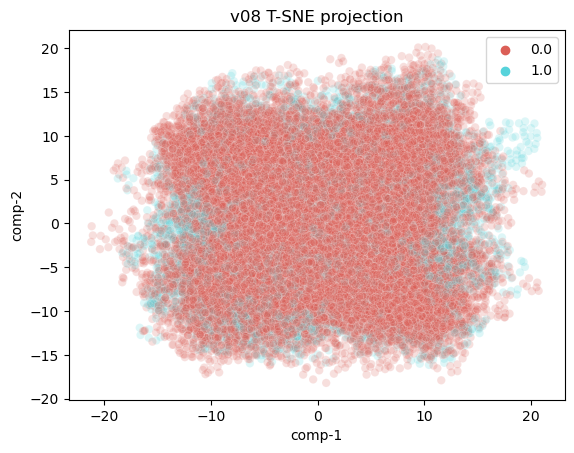

In [33]:
# Class count {0.0: 25095, 1.0: 16653} 
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=v08.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", 2),
                data=v08).set(title="v08 T-SNE projection");

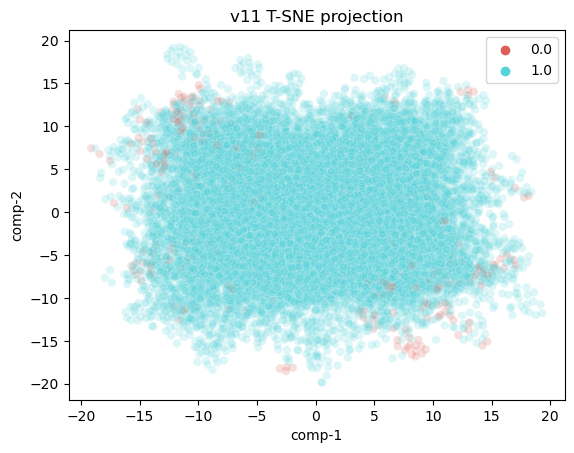

In [29]:
# Class count {0.0: 299, 1.0: 19301}
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=v11.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", 2),
                data=v11).set(title="v11 T-SNE projection");

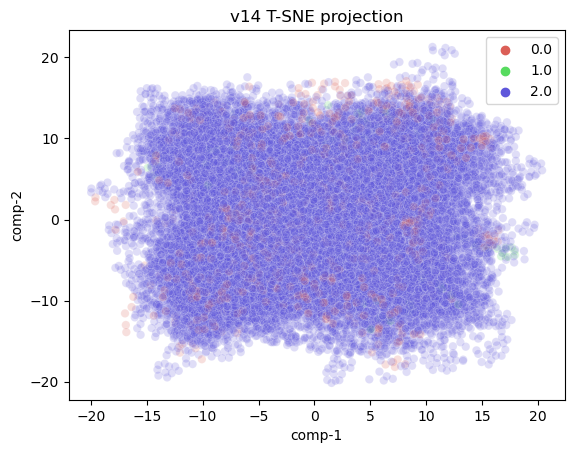

In [15]:
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=v14.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", 3),
                data=v14).set(title="v14 T-SNE projection");

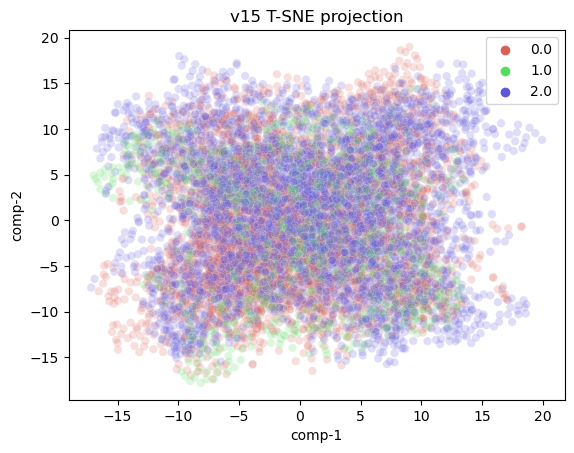

In [19]:
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=v15.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", 3),
                data=v15).set(title="v15 T-SNE projection");

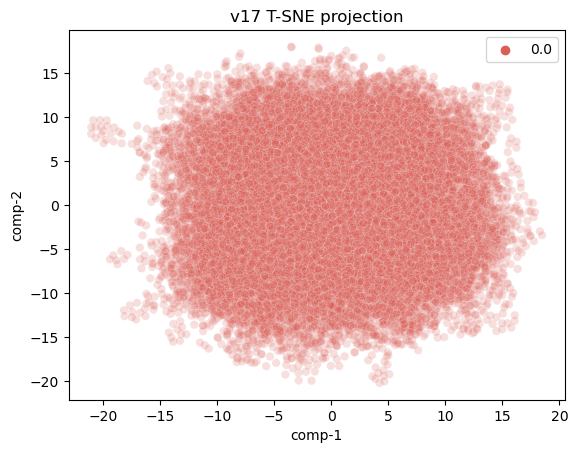

In [25]:
# this one is only natural forest
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=v17.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", 1),
                data=v17).set(title="v17 T-SNE projection");

### Scaled data

In [75]:
def tsne_visual(v_train_data, classes, scaling):
    
    X, y = pp.create_xy([v_train_data], 
                        classes=classes, 
                        drop_prob=False, 
                        drop_feats=False, 
                        feature_select=[],
                        verbose=True)

    # scale the data
    if scaling:
        for band in range(0, X.shape[-1]):

                mins = np.percentile(X[..., band], 1)
                maxs = np.percentile(X[..., band], 99)

                if maxs > mins:

                    # clip values in each band based on min/max of training dataset
                    X[..., band] = np.clip(X[..., band], mins, maxs)

                    # calculate standardized data
                    midrange = (maxs + mins) / 2
                    rng = maxs - mins
                    X_std = (X[..., band] - midrange) / (rng / 2)

                    # update each band in X to hold standardized data
                    X[..., band] = X_std

    df = pd.DataFrame(columns=['y','comp-1', 'comp-2'])
    n_samples = X.shape[0]

    for plot in range(n_samples):

        X_ = X[plot, ...]
        X_re = X_.reshape(X_.shape[0]*X_.shape[1],X_.shape[2])
        y_ = y[plot, ...]
        y_re = y_.reshape(y_.shape[0]*y_.shape[1])

        # n components defines the num of target dims
        # using default perplexity of 30
        tsne = TSNE(n_components=2, verbose=1, random_state=22)
        z = tsne.fit_transform(X_re) 

        for a, b, c in zip(y_re, z[:,0], z[:,1]):
            df = df.append({'y': a, 
                           'comp-1': b,
                           'comp-2': c},
                           ignore_index=True)    
    return df

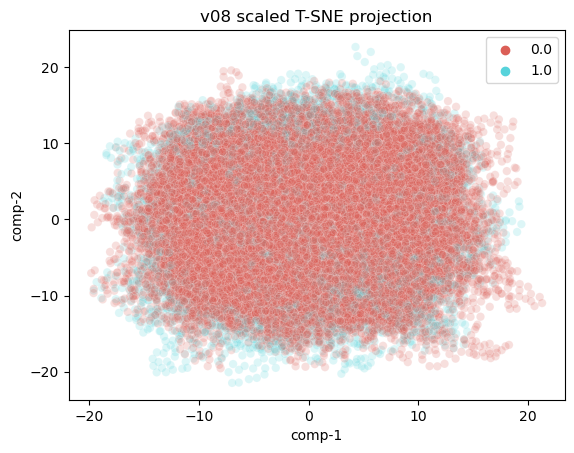

In [40]:
# uses default perplexity (30)
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=df.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", 2),
                data=df).set(title="v08 scaled T-SNE projection");

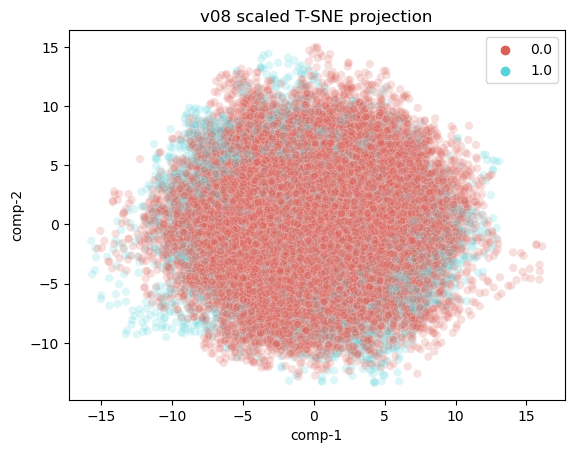

In [72]:
## Uses perplexity of 45
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=v08_sc.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", len(np.unique(v08_sc.y))),
                data=v08_sc).set(title="v08 scaled T-SNE projection");

In [2]:
#v11_sc = tsne_visual('v11', 'binary', True)

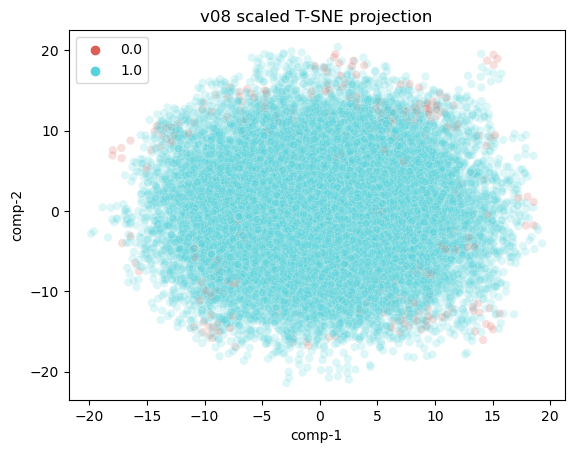

In [57]:
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=v11_sc.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", len(np.unique(v11_sc.y))),
                data=v11_sc).set(title="v08 scaled T-SNE projection");

## PCA
As a sanity check, and considering t-sne doesn't appear to work well, try running a Principle Component Analysis (PCA) to reduce the data to two dimensions. PCA is sensitive to scale so input features are scaled prior to fitting.

In [85]:
X, y = pp.create_xy(['v15'], 
                        classes='multi', 
                        drop_prob=False, 
                        drop_feats=False, 
                        feature_select=[],
                        verbose=True)

for band in range(0, X.shape[-1]):

    mins = np.percentile(X[..., band], 1)
    maxs = np.percentile(X[..., band], 99)

    if maxs > mins:

        # clip values in each band based on min/max of training dataset
        X[..., band] = np.clip(X[..., band], mins, maxs)

        # calculate standardized data
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        X_std = (X[..., band] - midrange) / (rng / 2)

        # update each band in X to hold standardized data
        X[..., band] = X_std
        

2.0 plots labeled unknown were dropped.
Training data includes 48 plots.
Class count {0.0: 4065, 1.0: 1167, 2.0: 4176}


In [86]:
df = pd.DataFrame(columns=['y','comp-1', 'comp-2'])
n_samples = X.shape[0]

for plot in range(n_samples):

    X_ = X[plot, ...]
    
    X_re = X_.reshape(X_.shape[0]*X_.shape[1],X_.shape[2])
    y_ = y[plot, ...]
    y_re = y_.reshape(y_.shape[0]*y_.shape[1])

    # n components defines the num of target dims
    # using default perplexity of 30
    pca = PCA(n_components=2, random_state=22)
    z = pca.fit_transform(X_re) 

    for a, b, c in zip(y_re, z[:,0], z[:,1]):
        df = df.append({'y': a, 
                       'comp-1': b,
                       'comp-2': c},
                       ignore_index=True)  

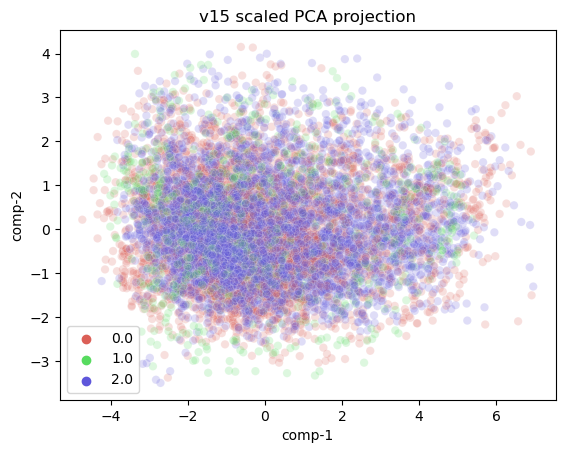

In [87]:
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=df.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", len(np.unique(df.y))),
                data=df).set(title="v15 scaled PCA projection");

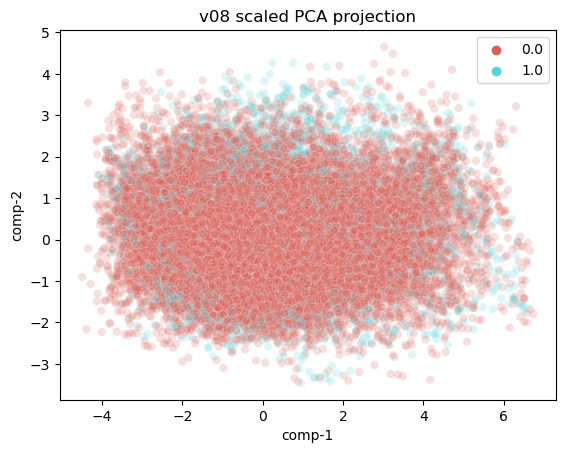

In [78]:
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=df.y.tolist(),
                alpha=0.2,
                palette=sns.color_palette("hls", len(np.unique(df.y))),
                data=df).set(title="v08 scaled PCA projection");

## Conclusions
* We would expect (hope for) greater separation between the 1 and 0 classes for v08 and v11, which have binary plantation / non-plantation labels. We anticipate the model will struggle with separating 0, 1 and 2 classes for v14 and v15. Overall, this exercise shows little to no ability to separate between classes.
  
_Other tests performed:_  
* In the event t-sne is sensitive to the varying scales of the input features, the analysis is performed with scaled and unscaled data. No differences in the output visualization were documented when scaling is applied to v08 and v11.
* In the event the incorrect perplexity value was selected, a range of values were tested for v08 (including 5, 30 and 45). Increasing the perplexity to 45 reduced the spread of the data but didn't impact cluster separability. No significant differences in the output visualization were documented when perplexity values were changed.
* In the event there's an error in the t-sne analysis, PCA is applied to the data to reduce it to two dimensions. This also gives bad results, which indicates the data is not very structured.

### References
https://lvdmaaten.github.io/tsne/  
https://crunchingthedata.com/when-to-use-t-sne/#:~:text=Like%20many%20other%20dimension%20reduction,undue%20influence%20on%20the%20results.  

# Analysis Ready Data (ARD) Comparison [Deployment]

In [12]:
# check out a couple of examples
def multiplot(matrices, cbarmin, cbarmax,  nrows = 13, ncols = 6):
    '''
    
    '''
    fig, axs = plt.subplots(ncols = ncols, nrows = nrows)
    fig.set_size_inches(18, 3.25*nrows)
    
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    counter = 0
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        
        for i in range(ncols):
            sns.heatmap(data = matrices[..., counter], ax = axs[r - 1, i], cbar = True, 
                        vmin=matrices[..., counter].min(), vmax=matrices[..., counter].max(), #could also change to cbarmin
                       cmap = sns.color_palette("viridis", as_cmap=True))
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
            counter += 1
        
    plt.show

In [3]:
## Check ard
country = 'ghana'
x=1667
y=1077
ard = hkl.load(f'../tmp/{country}/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}_ard.hkl')
ard.shape

(618, 614, 13)

## Sentinel-2

In [33]:
#(1668, 1076)
# load my processed s2, dem, s1 data
my_s2 = hkl.load('../data/processed_files/s2_ghana.hkl')
my_s1 = hkl.load('../data/processed_files/s1_ghana.hkl')
my_dem = hkl.load('../data/processed_files/dem_ghana.hkl')
my_s2.shape, my_s1.shape, my_dem.shape

((618, 614, 10), (618, 614, 2), (618, 614))

In [34]:
# load ARD and separate into s2, dem, s1
ard = hkl.load('../data/1668X1076_ard.hkl')
ard_s2 = ard[..., 0:10]
ard_dem = ard[..., 10:11]
ard_s1 = ard[..., 11:13]
ard.shape

(618, 614, 13)

In [1]:
#multiplot(my_s2, 0, 0.55, 2, 5)

In [2]:
#multiplot(ard_s2, 0, 0.55, 2, 5)

## Texture

In [73]:
# is the texture calc the same?
# pay note to the different cbar values
x=1667
y=1077
ard_txt = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt_ard.npy')
my_txt = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txtv19.npy')

In [3]:
#multiplot(my_txt, 2, 4)

## Check Artifacts & Erroneous Predictions

In [64]:
x=1656
y=1068
ard = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}Y_ard.hkl')
txt = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy')
feats = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_feats.hkl')

x=1657
y=1068
ard2 = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}Y_ard.hkl')
txt2 = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy')
feats2 = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_feats.hkl')

test = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_TEST.npy')
test.shape

(618, 614, 81)

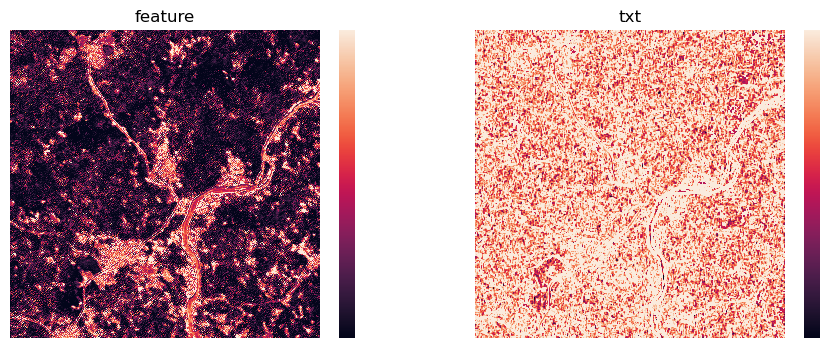

In [68]:
make.heat_compare_arrays(test[..., 1], test[...,70], test[..., 60].min(), test[..., 60].max(),  'feature', 'txt')

In [59]:
ard2.shape, feats2.shape

((618, 614, 13), (65, 614, 618))

In [60]:
feats_rolled = np.rollaxis(feats2, 0, 3)
feats_rolled = np.rollaxis(feats_rolled, 0, 2)
feats_rolled.shape

(618, 614, 65)

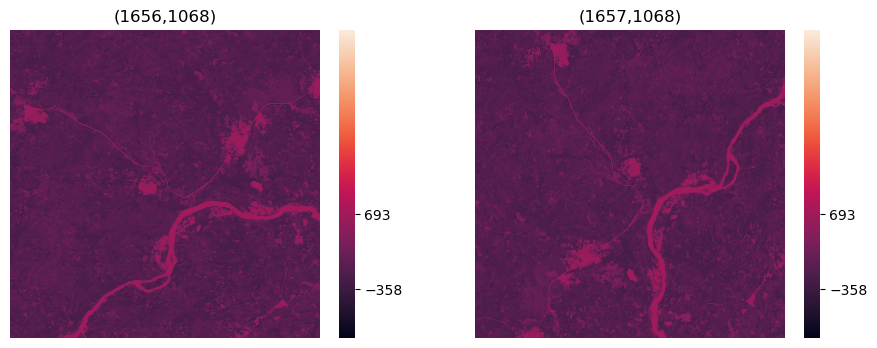

In [63]:
make.heat_compare_arrays(feats2[1,...], feats_rolled[...,1], feats_rolled[1,...].min(), feats_rolled[1,...].max(),  '(1656,1068)', '(1657,1068)')


### Compare predictions

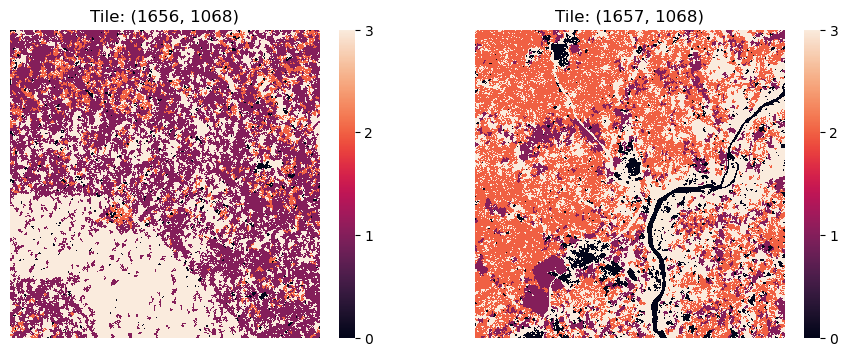

In [23]:
make.heat_compare_preds('ghana', (1656,1068),(1657,1068))

### Compare TTC features

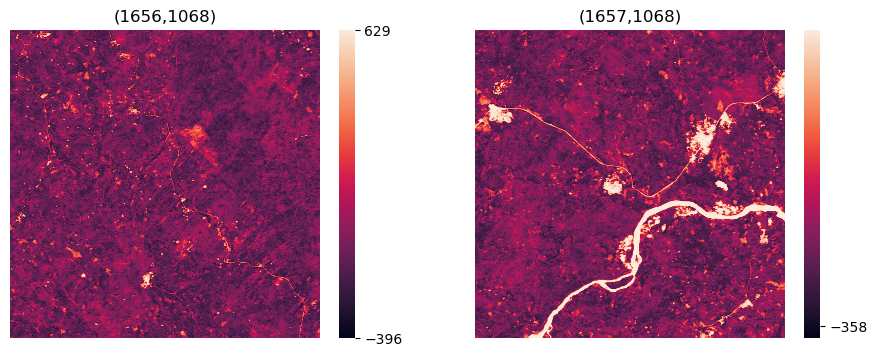

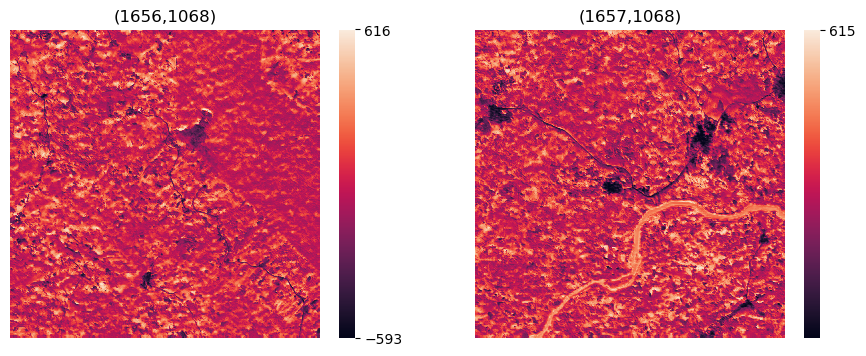

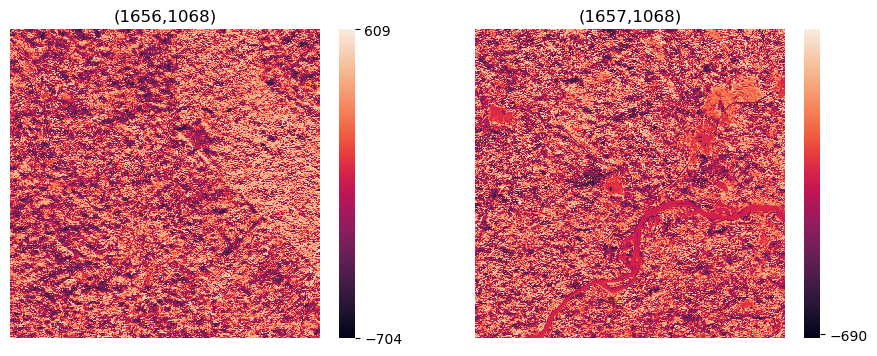

In [35]:
make.heat_compare_arrays(feats[1,...], feats2[1,...], feats[1,...].min(), feats[1,...].max(),  '(1656,1068)', '(1657,1068)')
make.heat_compare_arrays(feats[5,...], feats2[5,...], feats[5,...].min(), feats[5,...].max(),  '(1656,1068)', '(1657,1068)')
make.heat_compare_arrays(feats[6,...], feats2[6,...], feats[6,...].min(), feats[6,...].max(),  '(1656,1068)', '(1657,1068)')

### Compare dem and s1

In [1]:
# make.heat_compare_arrays(ard[...,2], ard2[...,2], ard[...,2].min(), ard[...,2].max(), 's2 (1656,1068)', 's2 (1657,1068)') 
# make.heat_compare_arrays(ard[...,10], ard2[...,10], ard[...,10].min(), ard[...,10].max(), 'dem (1656,1068)', 'dem (1657,1068)') 
# make.heat_compare_arrays(ard[...,11], ard2[...,11], ard[...,11].min(), ard[...,11].max(), 's1 (1656,1068)', 's1 (1657,1068)') 
# make.heat_compare_arrays(ard[...,12], ard2[...,12], ard[...,12].min(), ard[...,12].max(), 's1 (1656,1068)', 's1 (1657,1068)') 

### Compare s2 bands

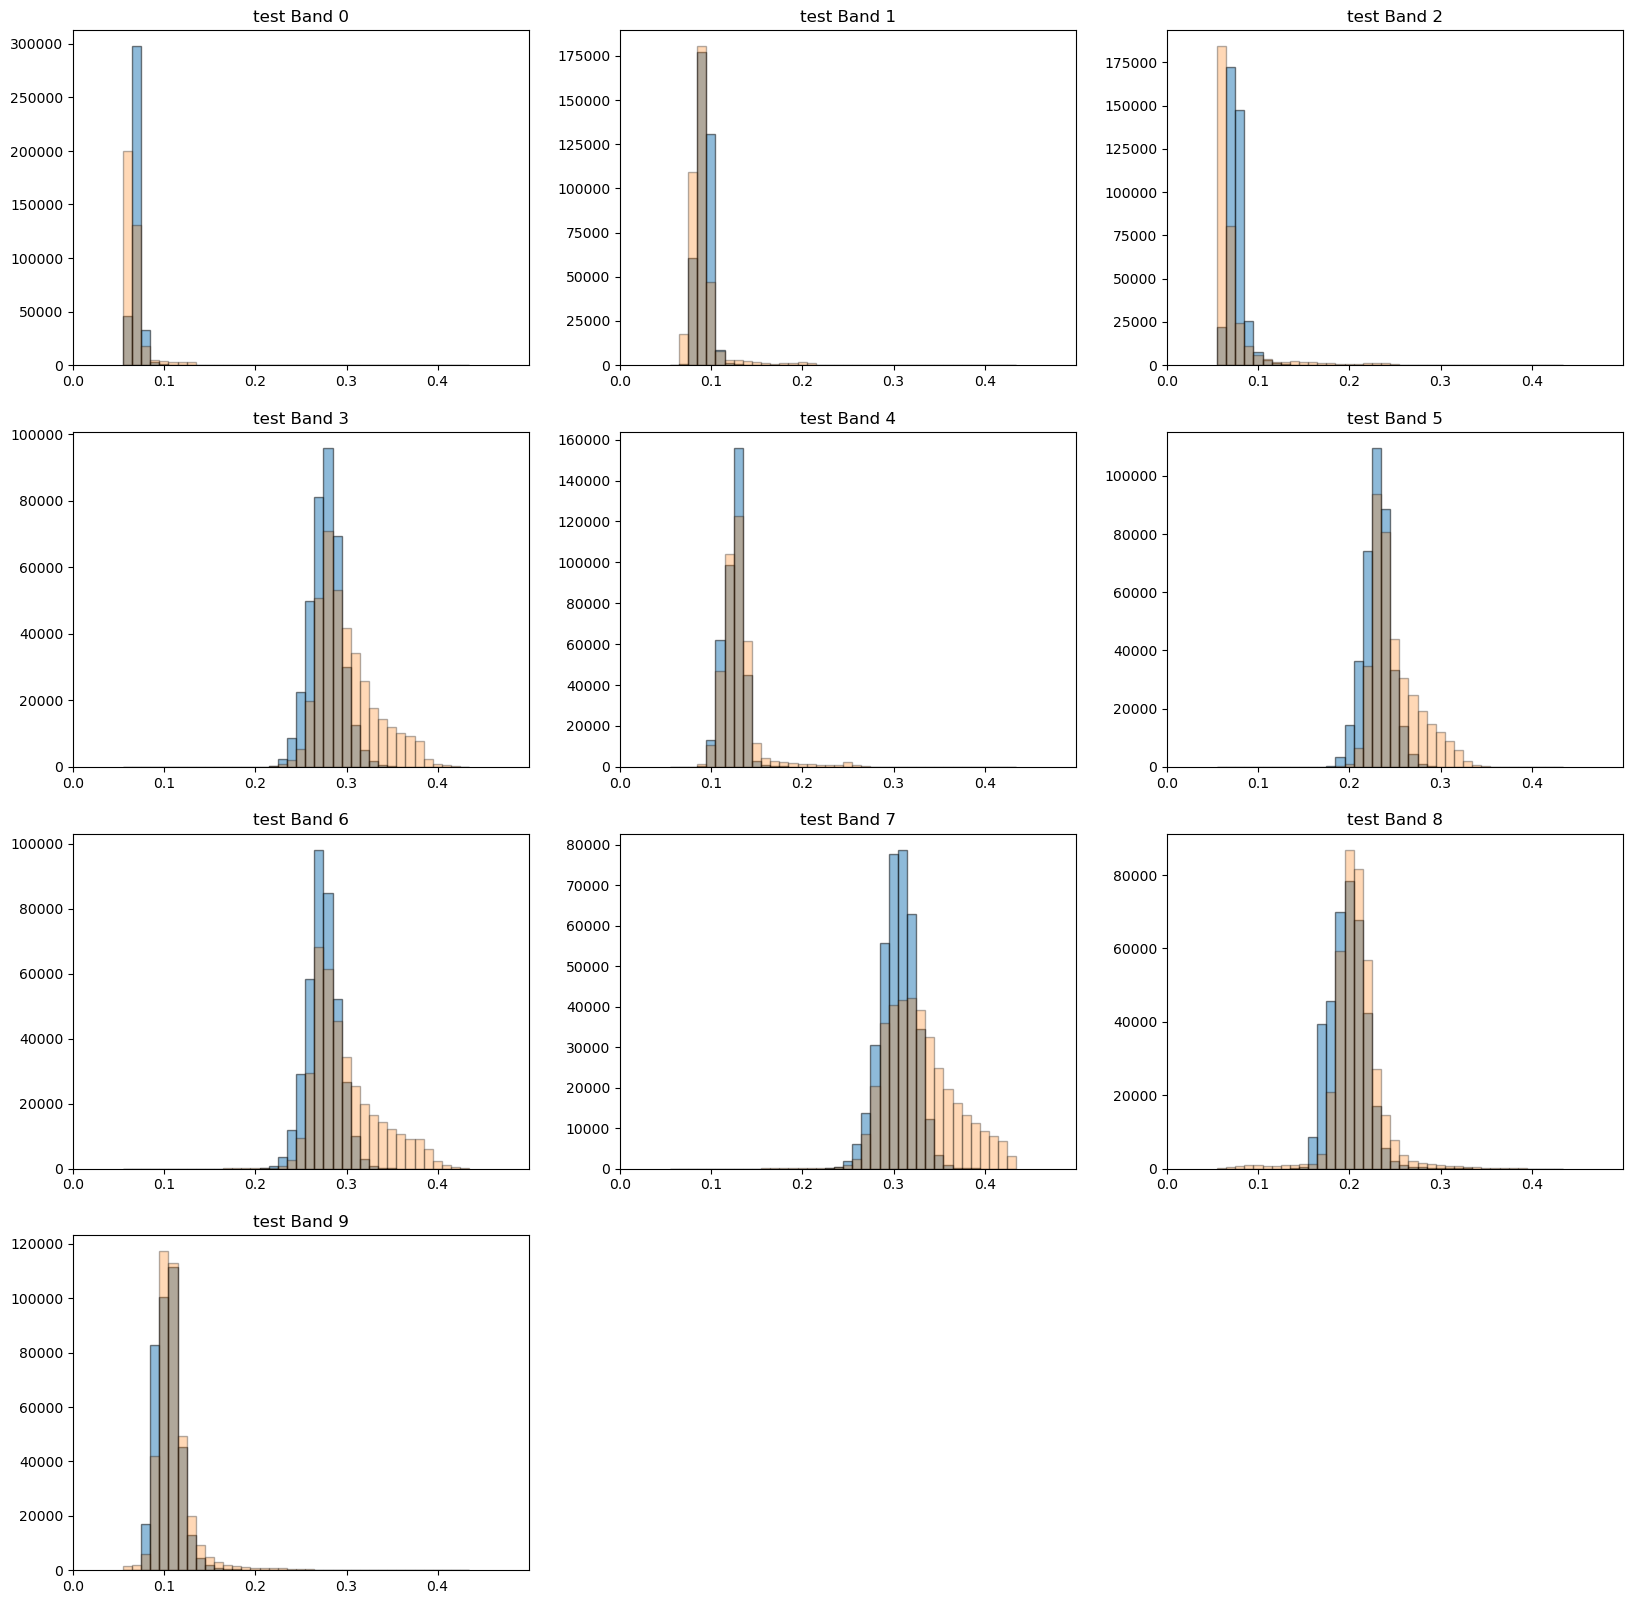

In [24]:
make.hist_compare_s2_byband('ghana', (1656, 1068), (1657, 1068), 'test')

### Compare texture

In [2]:
# make.heat_compare_arrays(txt[...,13], txt2[...,13], txt[...,13].min(), txt[...,13].max(), '(1656,1068)', '(1657,1068)')
# make.heat_compare_arrays(txt[...,15], txt2[...,15], txt[...,15].min(), txt[...,15].max(), '(1656,1068)', '(1657,1068)')

## Compare Predictions

In [47]:
x=1660
y=1068
ard = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}Y_ard.hkl')
txt = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy')
feats = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_feats.hkl')

x=1661
y=1068
ard2 = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}Y_ard.hkl')
txt2 = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy')
feats2 = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_feats.hkl')

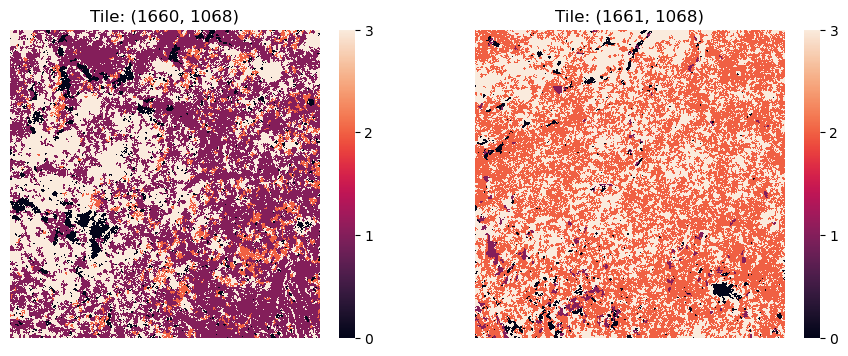

In [48]:
make.heat_compare_preds('ghana', (1660,1068),(1661,1068))

## Compare s2, dem, s1

In [3]:
# make.heat_compare_arrays(ard[...,2], ard2[...,2], ard[...,2].min(), ard[...,2].max(), 's2 (1656,1068)', 's2 (1657,1068)') 
# make.heat_compare_arrays(ard[...,10], ard2[...,10], ard[...,10].min(), ard[...,10].max(), 'dem (1656,1068)', 'dem (1657,1068)') 
# make.heat_compare_arrays(ard[...,11], ard2[...,11], ard[...,11].min(), ard[...,11].max(), 's1 (1656,1068)', 's1 (1657,1068)') 
# make.heat_compare_arrays(ard[...,12], ard2[...,12], ard[...,12].min(), ard[...,12].max(), 's1 (1656,1068)', 's1 (1657,1068)') 

## Compare TTC Feats

In [4]:
# make.heat_compare_arrays(feats[1,...], feats2[1,...], feats[1,...].min(), feats[1,...].max(),  '(1660,1068)', '(1661,1068)')
# make.heat_compare_arrays(feats[5,...], feats2[5,...], feats[5,...].min(), feats[5,...].max(),  '(1660,1068)', '(1661,1068)')
# make.heat_compare_arrays(feats[6,...], feats2[6,...], feats[6,...].min(), feats[6,...].max(),  '(1660,1068)', '(1661,1068)')

In [53]:
## Check area with minimal artifacting
x=1657
y=1067
ard = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}Y_ard.hkl')
txt = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy')
feats = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_feats.hkl')

x=1658
y=1067
ard2 = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}Y_ard.hkl')
txt2 = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy')
feats2 = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_feats.hkl')

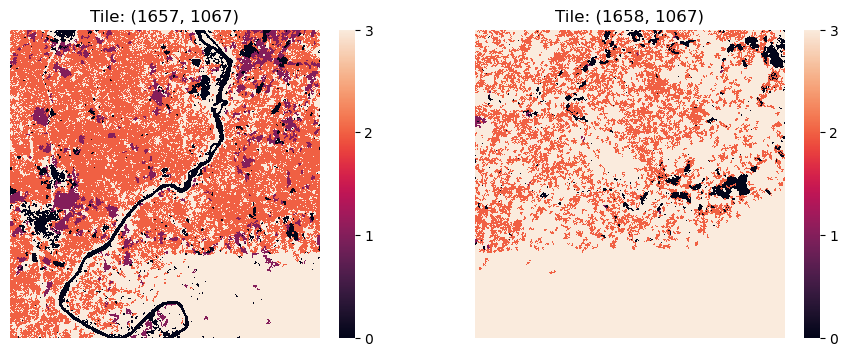

In [55]:
make.heat_compare_preds('ghana', (1657,1067),(1658,1067))

In [5]:
# make.heat_compare_arrays(feats[1,...], feats2[1,...], feats[1,...].min(), feats[1,...].max(),  '()', '( )')
# make.heat_compare_arrays(feats[5,...], feats2[5,...], feats[5,...].min(), feats[5,...].max(),  '( )', '()')
# make.heat_compare_arrays(feats[6,...], feats2[6,...], feats[6,...].min(), feats[6,...].max(),  '( )', '( )')

# Explore texture to develop validation checks

Ranges [Source: MathWorks](https://www.mathworks.com/help/images/ref/graycoprops.html)
- Contrast `Range = [0 (size(GLCM,1)-1)^2]`
- Correlation `Range = [-1 1]`
- Homogeneity `Range = [0 1]`  
The red band has outlier values for correlation, homogeneity and contrast when examined for 2 different texture arrays. Does this have something to do with the ARD? The first section only looks at two texture arrays created from the v1 ARD.

In [25]:
# download and compare one training tile from each CEO survey and compare
txt = np.load('../data/testing/1676X1158Y_txt.npy')
txt.shape

(618, 606, 16)

In [29]:
print('Order: blue, green, red, nir')
print('dissimilarity')
print(txt[...,0].min(), txt[...,0].max())
print(txt[...,4].min(), txt[...,4].max())
print(txt[...,8].min(), txt[...,8].max())
print(txt[...,12].min(), txt[...,12].max())
print('correlation')
print(txt[...,1].min(), txt[...,1].max())
print(txt[...,5].min(), txt[...,5].max())
print(txt[...,9].min(), txt[...,9].max())
print(txt[...,13].min(), txt[...,13].max())
print('homogeneity')
print(txt[...,2].min(), txt[...,2].max())
print(txt[...,6].min(), txt[...,6].max())
print(txt[...,10].min(), txt[...,10].max())
print(txt[...,14].min(), txt[...,14].max())
print('contrast')
print(txt[...,3].min(), txt[...,3].max())
print(txt[...,7].min(), txt[...,7].max())
print(txt[...,11].min(), txt[...,11].max())
print(txt[...,15].min(), txt[...,15].max())

Order: blue, green, red, nir
dissimilarity
0.0 5.8
0.0 7.4
0.0 10.3
0.05 29.35
correlation
-0.74535596 1.0
-0.85714287 1.0
-0.65186125 1.0
-0.6666667 1.0
homogeneity
0.0758217 1.0
0.045128282 1.0
0.021346407 1.0
0.0019076733 0.975
contrast
0.0 46.7
0.0 76.3
0.0 133.65
0.05 1004.85


In [27]:
txt = np.load('../data/testing/1652X1144Y_txt.npy')
txt.shape

(618, 608, 16)

In [30]:
print('Order: blue, green, red, nir')
print('dissimilarity')
print(txt[...,0].min(), txt[...,0].max())
print(txt[...,4].min(), txt[...,4].max())
print(txt[...,8].min(), txt[...,8].max())
print(txt[...,12].min(), txt[...,12].max())
print('correlation')
print(txt[...,1].min(), txt[...,1].max())
print(txt[...,5].min(), txt[...,5].max())
print(txt[...,9].min(), txt[...,9].max())
print(txt[...,13].min(), txt[...,13].max())
print('homogeneity')
print(txt[...,2].min(), txt[...,2].max())
print(txt[...,6].min(), txt[...,6].max())
print(txt[...,10].min(), txt[...,10].max())
print(txt[...,14].min(), txt[...,14].max())
print('contrast')
print(txt[...,3].min(), txt[...,3].max())
print(txt[...,7].min(), txt[...,7].max())
print(txt[...,11].min(), txt[...,11].max())
print(txt[...,15].min(), txt[...,15].max())

Order: blue, green, red, nir
dissimilarity
0.0 5.8
0.0 7.4
0.0 10.3
0.05 29.35
correlation
-0.74535596 1.0
-0.85714287 1.0
-0.65186125 1.0
-0.6666667 1.0
homogeneity
0.0758217 1.0
0.045128282 1.0
0.021346407 1.0
0.0019076733 0.975
contrast
0.0 46.7
0.0 76.3
0.0 133.65
0.05 1004.85


In [2]:
ghana = pd.read_csv('../data/ghana.csv')
len(ghana)

6342

In [3]:
tiles = ghana[['X_tile', 'Y_tile']].to_records(index=False)
tiles

rec.array([(1678, 1163), (1679, 1163), (1676, 1162), ..., (1648, 1049),
           (1649, 1049), (1650, 1049)],
          dtype=[('X_tile', '<i8'), ('Y_tile', '<i8')])

# Artifacts

Comparison of the following tiles
- left (1669, 1077) right (1670, 1077)
- bottom (1658, 1063) top (1658, 1064)
- left (1668, 1077) right (1669, 1077)

Comparing the following data
- raw sentinel 2
- ARD sentinel 2 (pre and post sept 15)
- features 

In [2]:
def comp(tile_idx_a, tile_idx_b):
    
    location = 'ghana'
    x_a, y_a = tile_idx_a[0], tile_idx_a[1]
    x_b, y_b = tile_idx_b[0], tile_idx_b[1]

    # import preds, ARD, feats and raw s2 data for the two tiles
    raw_s2_a = hkl.load(f'../tmp/{location}/{str(x_a)}/{str(y_a)}/raw/s2_10/{str(x_a)}X{str(y_a)}Y.hkl')
    raw_s2_b = hkl.load(f'../tmp/{location}/{str(x_b)}/{str(y_b)}/raw/s2_10/{str(x_b)}X{str(y_b)}Y.hkl')
    new_ard_a = hkl.load(f'../tmp/{location}/{str(x_a)}/{str(y_a)}/ard/{str(x_a)}X{str(y_a)}Y_ard.hkl')
    new_ard_b = hkl.load(f'../tmp/{location}/{str(x_b)}/{str(y_b)}/ard/{str(x_b)}X{str(y_b)}Y_ard.hkl')
    old_ard_a = hkl.load(f'../tmp/{location}/{str(x_a)}/{str(y_a)}/ard/{str(x_a)}X{str(y_a)}_ard.hkl')
    old_ard_b = hkl.load(f'../tmp/{location}/{str(x_b)}/{str(y_b)}/ard/{str(x_b)}X{str(y_b)}_ard.hkl')
    feats_a = hkl.load(f'../tmp/{location}/{str(x_a)}/{str(y_a)}/raw/feats/{str(x_a)}X{str(y_a)}Y_feats.hkl')
    feats_b = hkl.load(f'../tmp/{location}/{str(x_b)}/{str(y_b)}/raw/feats/{str(x_b)}X{str(y_b)}Y_feats.hkl')
    preds_a = rs.open(f'../tmp/{location}/preds/{str(x_a)}X{str(y_a)}Y_preds.tif').read(1)
    preds_b = rs.open(f'../tmp/{location}/preds/{str(x_b)}X{str(y_b)}Y_preds.tif').read(1)
    new_txt_a = np.load(f'../tmp/quickcheck/{str(x_a)}X{str(y_a)}Y_txt.npy')
    old_txt_a = np.load(f'../tmp/{location}/{str(x_a)}/{str(y_a)}/raw/feats/{str(x_a)}X{str(y_a)}Y_txt.npy')
    new_txt_b = np.load(f'../tmp/quickcheck/{str(x_b)}X{str(y_b)}Y_txt.npy')
    old_txt_b = np.load(f'../tmp/{location}/{str(x_b)}/{str(y_b)}/raw/feats/{str(x_b)}X{str(y_b)}Y_txt.npy')
    

    new_ard_s2_a = new_ard_a[..., 0:10]
    new_ard_s2_b = new_ard_b[..., 0:10]
    old_ard_s2_a = old_ard_a[..., 0:10]
    old_ard_s2_b = old_ard_b[..., 0:10]
    
    # compare raw s2
    make.heat_compare_hkl(raw_s2_a[3,...,3], raw_s2_b[3,...,3], 'Raw s2 (band 3)', 'Raw s2 (band 3)')
    # compare ard s2
    make.heat_compare_hkl(new_ard_s2_a[...,4], new_ard_s2_b[...,4], 'New ARD s2 (band 4)', 'New ARD s2 (band 4)')
    # compare OLD ard s2
    make.heat_compare_hkl(old_ard_s2_a[...,4], old_ard_s2_b[...,4], 'Old ARD s2 (band 4)', 'Old ARD s2 (band 4)')
    # compare old text
    make.heat_compare_hkl(old_txt_a[...,6], old_txt_b[...,6], 'Old text A (band 1)', 'Old text B(band 1)')
    # compare old text
    make.heat_compare_hkl(new_txt_a[...,6], new_txt_b[...,6], 'New text A (band 1)', 'New text B(band 1)')
    

#     new_feats = np.concatenate([feats_a, feats_b], axis = 1)
#     new_feats = np.moveaxis(new_feats, 0, 2)
#     new_feats = np.moveaxis(new_feats, 0, 1)
    
#     def arr_to_rgb(arr, start):
#         l = np.zeros_like(arr[..., :3])
#         l[..., 0] = np.copy(arr[..., start + 2])
#         l[..., 1] = np.copy(arr[..., start + 1])
#         l[..., 2] = np.copy(arr[..., start])
#         l = np.clip(l, 0, np.percentile(l, 99.999, axis = (0, 1)))
#         maxes = np.array(np.max(l, axis = (0, 1)))
#         l = l / maxes
#         l = Image.fromarray((l * 255).astype(np.uint8), 'RGB')
#         return l

#     for i in range(0, 5, 3):
#         im = arr_to_rgb(new_feats, i)
#         plt.figure(figsize=(12,4))
#         plt.imshow(im)
#         plt.title(i)
    
    return None

In [3]:
#comp((1669, 1077), (1670, 1077))

In [8]:
#comp((1668, 1077), (1669, 1077))

In [9]:
# bottom, top
#comp((1658, 1063), (1658, 1064))

# Local folder cleanout

In [6]:
for tile_idx in tiles:
    x = tile_idx[0]
    y = tile_idx[1]
    filepath = f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/'
    feats_exist = os.path.exists(filepath)
    if feats_exist:
        shutil.rmtree(filepath)
        print(f'Removed {filepath}')

Removed ../tmp/ghana/1676/1158/raw/feats/
Removed ../tmp/ghana/1652/1144/raw/feats/
Removed ../tmp/ghana/1680/1143/raw/feats/
Removed ../tmp/ghana/1690/1143/raw/feats/
Removed ../tmp/ghana/1673/1142/raw/feats/
Removed ../tmp/ghana/1659/1136/raw/feats/
Removed ../tmp/ghana/1657/1135/raw/feats/
Removed ../tmp/ghana/1667/1135/raw/feats/
Removed ../tmp/ghana/1674/1134/raw/feats/
Removed ../tmp/ghana/1686/1128/raw/feats/
Removed ../tmp/ghana/1670/1119/raw/feats/
Removed ../tmp/ghana/1683/1118/raw/feats/
Removed ../tmp/ghana/1684/1118/raw/feats/
Removed ../tmp/ghana/1673/1114/raw/feats/
Removed ../tmp/ghana/1647/1104/raw/feats/
Removed ../tmp/ghana/1688/1104/raw/feats/
Removed ../tmp/ghana/1660/1100/raw/feats/
Removed ../tmp/ghana/1661/1100/raw/feats/
Removed ../tmp/ghana/1660/1099/raw/feats/
Removed ../tmp/ghana/1661/1099/raw/feats/
Removed ../tmp/ghana/1667/1099/raw/feats/
Removed ../tmp/ghana/1673/1099/raw/feats/
Removed ../tmp/ghana/1658/1098/raw/feats/
Removed ../tmp/ghana/1659/1098/raw

Removed ../tmp/ghana/1668/1091/raw/feats/
Removed ../tmp/ghana/1669/1091/raw/feats/
Removed ../tmp/ghana/1670/1091/raw/feats/
Removed ../tmp/ghana/1671/1091/raw/feats/
Removed ../tmp/ghana/1672/1091/raw/feats/
Removed ../tmp/ghana/1673/1091/raw/feats/
Removed ../tmp/ghana/1674/1091/raw/feats/
Removed ../tmp/ghana/1675/1091/raw/feats/
Removed ../tmp/ghana/1676/1091/raw/feats/
Removed ../tmp/ghana/1633/1090/raw/feats/
Removed ../tmp/ghana/1645/1090/raw/feats/
Removed ../tmp/ghana/1646/1090/raw/feats/
Removed ../tmp/ghana/1648/1090/raw/feats/
Removed ../tmp/ghana/1649/1090/raw/feats/
Removed ../tmp/ghana/1650/1090/raw/feats/
Removed ../tmp/ghana/1651/1090/raw/feats/
Removed ../tmp/ghana/1652/1090/raw/feats/
Removed ../tmp/ghana/1653/1090/raw/feats/
Removed ../tmp/ghana/1654/1090/raw/feats/
Removed ../tmp/ghana/1655/1090/raw/feats/
Removed ../tmp/ghana/1656/1090/raw/feats/
Removed ../tmp/ghana/1657/1090/raw/feats/
Removed ../tmp/ghana/1658/1090/raw/feats/
Removed ../tmp/ghana/1659/1090/raw

Removed ../tmp/ghana/1652/1083/raw/feats/
Removed ../tmp/ghana/1653/1083/raw/feats/
Removed ../tmp/ghana/1654/1083/raw/feats/
Removed ../tmp/ghana/1655/1083/raw/feats/
Removed ../tmp/ghana/1656/1083/raw/feats/
Removed ../tmp/ghana/1657/1083/raw/feats/
Removed ../tmp/ghana/1658/1083/raw/feats/
Removed ../tmp/ghana/1659/1083/raw/feats/
Removed ../tmp/ghana/1660/1083/raw/feats/
Removed ../tmp/ghana/1661/1083/raw/feats/
Removed ../tmp/ghana/1662/1083/raw/feats/
Removed ../tmp/ghana/1663/1083/raw/feats/
Removed ../tmp/ghana/1664/1083/raw/feats/
Removed ../tmp/ghana/1665/1083/raw/feats/
Removed ../tmp/ghana/1666/1083/raw/feats/
Removed ../tmp/ghana/1667/1083/raw/feats/
Removed ../tmp/ghana/1668/1083/raw/feats/
Removed ../tmp/ghana/1669/1083/raw/feats/
Removed ../tmp/ghana/1643/1082/raw/feats/
Removed ../tmp/ghana/1644/1082/raw/feats/
Removed ../tmp/ghana/1645/1082/raw/feats/
Removed ../tmp/ghana/1646/1082/raw/feats/
Removed ../tmp/ghana/1647/1082/raw/feats/
Removed ../tmp/ghana/1648/1082/raw

Removed ../tmp/ghana/1668/1074/raw/feats/
Removed ../tmp/ghana/1669/1074/raw/feats/
Removed ../tmp/ghana/1670/1074/raw/feats/
Removed ../tmp/ghana/1671/1074/raw/feats/
Removed ../tmp/ghana/1651/1073/raw/feats/
Removed ../tmp/ghana/1652/1073/raw/feats/
Removed ../tmp/ghana/1653/1073/raw/feats/
Removed ../tmp/ghana/1654/1073/raw/feats/
Removed ../tmp/ghana/1655/1073/raw/feats/
Removed ../tmp/ghana/1656/1073/raw/feats/
Removed ../tmp/ghana/1657/1073/raw/feats/
Removed ../tmp/ghana/1658/1073/raw/feats/
Removed ../tmp/ghana/1659/1073/raw/feats/
Removed ../tmp/ghana/1660/1073/raw/feats/
Removed ../tmp/ghana/1661/1073/raw/feats/
Removed ../tmp/ghana/1662/1073/raw/feats/
Removed ../tmp/ghana/1663/1073/raw/feats/
Removed ../tmp/ghana/1667/1073/raw/feats/
Removed ../tmp/ghana/1668/1073/raw/feats/
Removed ../tmp/ghana/1669/1073/raw/feats/
Removed ../tmp/ghana/1670/1073/raw/feats/
Removed ../tmp/ghana/1671/1073/raw/feats/
Removed ../tmp/ghana/1651/1072/raw/feats/
Removed ../tmp/ghana/1652/1072/raw

In [7]:
# delete old ARD, stored without Y
counter = 0
for tile_idx in tiles:
    x = tile_idx[0]
    y = tile_idx[1]
    filepath = f'../tmp/ghana/{str(x)}/{str(y)}/ard/'
    feats_exist = os.path.exists(filepath)
    if feats_exist:
        shutil.rmtree(filepath)
        print(f'Removed {filepath}')
        counter += 1
        
print(f'{counter} files deleted')

Removed ../tmp/ghana/1676/1158/ard/
Removed ../tmp/ghana/1652/1144/ard/
Removed ../tmp/ghana/1680/1143/ard/
Removed ../tmp/ghana/1690/1143/ard/
Removed ../tmp/ghana/1673/1142/ard/
Removed ../tmp/ghana/1659/1136/ard/
Removed ../tmp/ghana/1657/1135/ard/
Removed ../tmp/ghana/1667/1135/ard/
Removed ../tmp/ghana/1674/1134/ard/
Removed ../tmp/ghana/1686/1128/ard/
Removed ../tmp/ghana/1670/1119/ard/
Removed ../tmp/ghana/1683/1118/ard/
Removed ../tmp/ghana/1684/1118/ard/
Removed ../tmp/ghana/1673/1114/ard/
Removed ../tmp/ghana/1647/1104/ard/
Removed ../tmp/ghana/1688/1104/ard/
Removed ../tmp/ghana/1660/1098/ard/
Removed ../tmp/ghana/1661/1098/ard/
Removed ../tmp/ghana/1662/1098/ard/
Removed ../tmp/ghana/1666/1098/ard/
Removed ../tmp/ghana/1667/1093/ard/
Removed ../tmp/ghana/1633/1090/ard/
Removed ../tmp/ghana/1653/1086/ard/
Removed ../tmp/ghana/1658/1082/ard/
Removed ../tmp/ghana/1667/1077/ard/
Removed ../tmp/ghana/1668/1077/ard/
Removed ../tmp/ghana/1669/1077/ard/
Removed ../tmp/ghana/1670/10

In [7]:
# delete abirem texture files
df = pd.read_csv('../data/abirem_reprocess.csv')
tiles = df[['X_tile', 'Y_tile']].to_records(index=False)
for tile_idx in tiles:
    x = tile_idx[0]
    y = tile_idx[1]
    filepath = f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy'
    feats_exist = os.path.exists(filepath)
    if feats_exist:
        os.remove(filepath)
        print(f'Removed {filepath}')

Removed ../tmp/ghana/1668/1077/raw/feats/1668X1077Y_txt.npy
Removed ../tmp/ghana/1669/1077/raw/feats/1669X1077Y_txt.npy
Removed ../tmp/ghana/1670/1077/raw/feats/1670X1077Y_txt.npy
Removed ../tmp/ghana/1670/1075/raw/feats/1670X1075Y_txt.npy
Removed ../tmp/ghana/1668/1074/raw/feats/1668X1074Y_txt.npy
Removed ../tmp/ghana/1669/1074/raw/feats/1669X1074Y_txt.npy
Removed ../tmp/ghana/1670/1074/raw/feats/1670X1074Y_txt.npy
Removed ../tmp/ghana/1668/1073/raw/feats/1668X1073Y_txt.npy


# s3 File rename

In [40]:
## there is no rename - must copy the object with a new name then delete the old one

def rename_s3_file(old_file_key, new_file_key):

    with open("../config.yaml", 'r') as stream:
        document = (yaml.safe_load(stream))
        aak = document['aws']['aws_access_key_id']
        ask = document['aws']['aws_secret_access_key']

    s3 = boto3.resource('s3',
                        aws_access_key_id=aak, 
                        aws_secret_access_key=ask)
    
    bucket = 'tof-output'
    try:
        s3.Object(bucket, new_file_key).copy_from(CopySource={'Bucket': bucket, 'Key': old_file_key})
        s3.Object(bucket, old_file_key).delete()
        print(f'Renamed: {old_file_key}')
    except s3.meta.client.exceptions.NoSuchKey:
        print(f'{old_file_key} is not in bucket, skipping...')
    
    return None

In [38]:
## STEP 1: first rename the old file w correct naming convention to v0723
## delete the original
# note the print statements change

database = pd.read_csv('../data/ghana_feats_ard_reprocess.csv')
tiles = database[['X_tile', 'Y_tile']].to_records(index=False)
    
for tile_idx in tiles:
    x = tile_idx[0]
    y = tile_idx[1]
    
    # adds version
    old_ard = f'2020/ard/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_ard.hkl'
    new_ard = f'2020/ard/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_ard_v0723.hkl'
    
    rename_s3_file(old_ard, new_ard)

Renaming: 2020/ard/1651/1056/1651X1056Y_ard.hkl
2020/ard/1651/1056/1651X1056Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1648/1053/1648X1053Y_ard.hkl
2020/ard/1648/1053/1648X1053Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1624/1060/1624X1060Y_ard.hkl
2020/ard/1624/1060/1624X1060Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1649/1053/1649X1053Y_ard.hkl
2020/ard/1649/1053/1649X1053Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1619/1057/1619X1057Y_ard.hkl
2020/ard/1619/1057/1619X1057Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1658/1063/1658X1063Y_ard.hkl
Renaming: 2020/ard/1665/1075/1665X1075Y_ard.hkl
2020/ard/1665/1075/1665X1075Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1620/1057/1620X1057Y_ard.hkl
2020/ard/1620/1057/1620X1057Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1659/1063/1659X1063Y_ard.hkl
2020/ard/1659/1063/1659X1063Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1669/

2020/ard/1606/1077/1606X1077Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1668/1123/1668X1123Y_ard.hkl
2020/ard/1668/1123/1668X1123Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1590/1097/1590X1097Y_ard.hkl
2020/ard/1590/1097/1590X1097Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1645/1097/1645X1097Y_ard.hkl
2020/ard/1645/1097/1645X1097Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1613/1097/1613X1097Y_ard.hkl
2020/ard/1613/1097/1613X1097Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1649/1075/1649X1075Y_ard.hkl
2020/ard/1649/1075/1649X1075Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1575/1121/1575X1121Y_ard.hkl
2020/ard/1575/1121/1575X1121Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1634/1125/1634X1125Y_ard.hkl
2020/ard/1634/1125/1634X1125Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1592/1141/1592X1141Y_ard.hkl
2020/ard/1592/1141/1592X1141Y_ard.hkl is not in bucket, skipping...
Rena

Renaming: 2020/ard/1659/1073/1659X1073Y_ard.hkl
2020/ard/1659/1073/1659X1073Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1662/1068/1662X1068Y_ard.hkl
Renaming: 2020/ard/1643/1064/1643X1064Y_ard.hkl
2020/ard/1643/1064/1643X1064Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1670/1079/1670X1079Y_ard.hkl
2020/ard/1670/1079/1670X1079Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1633/1068/1633X1068Y_ard.hkl
2020/ard/1633/1068/1633X1068Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1648/1083/1648X1083Y_ard.hkl
Renaming: 2020/ard/1663/1081/1663X1081Y_ard.hkl
2020/ard/1663/1081/1663X1081Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1673/1079/1673X1079Y_ard.hkl
Renaming: 2020/ard/1651/1075/1651X1075Y_ard.hkl
2020/ard/1651/1075/1651X1075Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1635/1083/1635X1083Y_ard.hkl
2020/ard/1635/1083/1635X1083Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1646/1088/1646X1088Y_ard.

2020/ard/1637/1079/1637X1079Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1664/1060/1664X1060Y_ard.hkl
2020/ard/1664/1060/1664X1060Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1664/1086/1664X1086Y_ard.hkl
2020/ard/1664/1086/1664X1086Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1639/1073/1639X1073Y_ard.hkl
2020/ard/1639/1073/1639X1073Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1645/1072/1645X1072Y_ard.hkl
2020/ard/1645/1072/1645X1072Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1648/1057/1648X1057Y_ard.hkl
2020/ard/1648/1057/1648X1057Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1641/1070/1641X1070Y_ard.hkl
2020/ard/1641/1070/1641X1070Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1630/1077/1630X1077Y_ard.hkl
2020/ard/1630/1077/1630X1077Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1640/1066/1640X1066Y_ard.hkl
2020/ard/1640/1066/1640X1066Y_ard.hkl is not in bucket, skipping...
Rena

Renaming: 2020/ard/1645/1083/1645X1083Y_ard.hkl
Renaming: 2020/ard/1654/1080/1654X1080Y_ard.hkl
2020/ard/1654/1080/1654X1080Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1654/1081/1654X1081Y_ard.hkl
2020/ard/1654/1081/1654X1081Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1653/1080/1653X1080Y_ard.hkl
2020/ard/1653/1080/1653X1080Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1653/1081/1653X1081Y_ard.hkl
2020/ard/1653/1081/1653X1081Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1677/1072/1677X1072Y_ard.hkl
2020/ard/1677/1072/1677X1072Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1676/1072/1676X1072Y_ard.hkl
2020/ard/1676/1072/1676X1072Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1677/1073/1677X1073Y_ard.hkl
2020/ard/1677/1073/1677X1073Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1676/1073/1676X1073Y_ard.hkl
2020/ard/1676/1073/1676X1073Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1675/

2020/ard/1652/1052/1652X1052Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1650/1069/1650X1069Y_ard.hkl
2020/ard/1650/1069/1650X1069Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1656/1059/1656X1059Y_ard.hkl
2020/ard/1656/1059/1656X1059Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1645/1069/1645X1069Y_ard.hkl
2020/ard/1645/1069/1645X1069Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1647/1051/1647X1051Y_ard.hkl
2020/ard/1647/1051/1647X1051Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1639/1067/1639X1067Y_ard.hkl
2020/ard/1639/1067/1639X1067Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1657/1061/1657X1061Y_ard.hkl
2020/ard/1657/1061/1657X1061Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1639/1055/1639X1055Y_ard.hkl
2020/ard/1639/1055/1639X1055Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1661/1061/1661X1061Y_ard.hkl
2020/ard/1661/1061/1661X1061Y_ard.hkl is not in bucket, skipping...
Rena

Renaming: 2020/ard/1634/1087/1634X1087Y_ard.hkl
2020/ard/1634/1087/1634X1087Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1636/1085/1636X1085Y_ard.hkl
2020/ard/1636/1085/1636X1085Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1638/1083/1638X1083Y_ard.hkl
2020/ard/1638/1083/1638X1083Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1638/1080/1638X1080Y_ard.hkl
2020/ard/1638/1080/1638X1080Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1639/1080/1639X1080Y_ard.hkl
2020/ard/1639/1080/1639X1080Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1632/1085/1632X1085Y_ard.hkl
2020/ard/1632/1085/1632X1085Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1632/1086/1632X1086Y_ard.hkl
2020/ard/1632/1086/1632X1086Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1637/1084/1637X1084Y_ard.hkl
2020/ard/1637/1084/1637X1084Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1634/1091/1634X1091Y_ard.hkl
2020/ard/1634/1091/1634X

2020/ard/1603/1059/1603X1059Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1604/1059/1604X1059Y_ard.hkl
2020/ard/1604/1059/1604X1059Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1605/1060/1605X1060Y_ard.hkl
2020/ard/1605/1060/1605X1060Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1606/1060/1606X1060Y_ard.hkl
2020/ard/1606/1060/1606X1060Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1605/1059/1605X1059Y_ard.hkl
2020/ard/1605/1059/1605X1059Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1604/1061/1604X1061Y_ard.hkl
2020/ard/1604/1061/1604X1061Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1605/1061/1605X1061Y_ard.hkl
2020/ard/1605/1061/1605X1061Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1599/1060/1599X1060Y_ard.hkl
2020/ard/1599/1060/1599X1060Y_ard.hkl is not in bucket, skipping...
Renaming: 2020/ard/1599/1059/1599X1059Y_ard.hkl
2020/ard/1599/1059/1599X1059Y_ard.hkl is not in bucket, skipping...
Rena

In [41]:
## STEP 2: rename the new file that is missing a "Y" to proper naming convention
## delete the old file w incorrect naming convention

database = pd.read_csv('../data/ghana_feats_ard_reprocess.csv')
tiles = database[['X_tile', 'Y_tile']].to_records(index=False)
    
for tile_idx in tiles[1:]:
    x = tile_idx[0]
    y = tile_idx[1]
    
    # adds a Y
    old_ard = f'2020/ard/{str(x)}/{str(y)}/{str(x)}X{str(y)}_ard.hkl'
    new_ard = f'2020/ard/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_ard.hkl'
    
    rename_s3_file(old_ard, new_ard)

Renamed: 2020/ard/1651/1056/1651X1056_ard.hkl
Renamed: 2020/ard/1648/1053/1648X1053_ard.hkl
2020/ard/1624/1060/1624X1060_ard.hkl is not in bucket, skipping...
Renamed: 2020/ard/1649/1053/1649X1053_ard.hkl
2020/ard/1619/1057/1619X1057_ard.hkl is not in bucket, skipping...
Renamed: 2020/ard/1658/1063/1658X1063_ard.hkl
Renamed: 2020/ard/1665/1075/1665X1075_ard.hkl
2020/ard/1620/1057/1620X1057_ard.hkl is not in bucket, skipping...
Renamed: 2020/ard/1659/1063/1659X1063_ard.hkl
Renamed: 2020/ard/1669/1077/1669X1077_ard.hkl
2020/ard/1623/1057/1623X1057_ard.hkl is not in bucket, skipping...
2020/ard/1625/1060/1625X1060_ard.hkl is not in bucket, skipping...
2020/ard/1621/1062/1621X1062_ard.hkl is not in bucket, skipping...
2020/ard/1622/1057/1622X1057_ard.hkl is not in bucket, skipping...
Renamed: 2020/ard/1670/1078/1670X1078_ard.hkl
Renamed: 2020/ard/1658/1064/1658X1064_ard.hkl
2020/ard/1621/1057/1621X1057_ard.hkl is not in bucket, skipping...
2020/ard/1623/1056/1623X1056_ard.hkl is not in buc

Renamed: 2020/ard/1668/1073/1668X1073_ard.hkl
Renamed: 2020/ard/1642/1069/1642X1069_ard.hkl
Renamed: 2020/ard/1657/1067/1657X1067_ard.hkl
Renamed: 2020/ard/1679/1071/1679X1071_ard.hkl
2020/ard/1629/1089/1629X1089_ard.hkl is not in bucket, skipping...
Renamed: 2020/ard/1642/1062/1642X1062_ard.hkl
Renamed: 2020/ard/1659/1073/1659X1073_ard.hkl
Renamed: 2020/ard/1662/1068/1662X1068_ard.hkl
Renamed: 2020/ard/1643/1064/1643X1064_ard.hkl
Renamed: 2020/ard/1670/1079/1670X1079_ard.hkl
Renamed: 2020/ard/1633/1068/1633X1068_ard.hkl
Renamed: 2020/ard/1648/1083/1648X1083_ard.hkl
Renamed: 2020/ard/1663/1081/1663X1081_ard.hkl
Renamed: 2020/ard/1673/1079/1673X1079_ard.hkl
Renamed: 2020/ard/1651/1075/1651X1075_ard.hkl
Renamed: 2020/ard/1635/1083/1635X1083_ard.hkl
Renamed: 2020/ard/1646/1088/1646X1088_ard.hkl
Renamed: 2020/ard/1653/1078/1653X1078_ard.hkl
Renamed: 2020/ard/1674/1077/1674X1077_ard.hkl
Renamed: 2020/ard/1645/1062/1645X1062_ard.hkl
Renamed: 2020/ard/1652/1054/1652X1054_ard.hkl
Renamed: 2020

Renamed: 2020/ard/1668/1061/1668X1061_ard.hkl
Renamed: 2020/ard/1660/1070/1660X1070_ard.hkl
Renamed: 2020/ard/1658/1066/1658X1066_ard.hkl
Renamed: 2020/ard/1668/1064/1668X1064_ard.hkl
Renamed: 2020/ard/1658/1055/1658X1055_ard.hkl
Renamed: 2020/ard/1647/1075/1647X1075_ard.hkl
Renamed: 2020/ard/1665/1059/1665X1059_ard.hkl
Renamed: 2020/ard/1663/1056/1663X1056_ard.hkl
Renamed: 2020/ard/1652/1071/1652X1071_ard.hkl
Renamed: 2020/ard/1674/1065/1674X1065_ard.hkl
Renamed: 2020/ard/1664/1070/1664X1070_ard.hkl
Renamed: 2020/ard/1666/1058/1666X1058_ard.hkl
Renamed: 2020/ard/1663/1068/1663X1068_ard.hkl
Renamed: 2020/ard/1671/1063/1671X1063_ard.hkl
Renamed: 2020/ard/1664/1063/1664X1063_ard.hkl
Renamed: 2020/ard/1676/1065/1676X1065_ard.hkl
Renamed: 2020/ard/1658/1069/1658X1069_ard.hkl
Renamed: 2020/ard/1670/1057/1670X1057_ard.hkl
Renamed: 2020/ard/1672/1061/1672X1061_ard.hkl
Renamed: 2020/ard/1667/1069/1667X1069_ard.hkl
Renamed: 2020/ard/1676/1076/1676X1076_ard.hkl
Renamed: 2020/ard/1685/1074/1685X1

2020/ard/1632/1060/1632X1060_ard.hkl is not in bucket, skipping...
2020/ard/1631/1060/1631X1060_ard.hkl is not in bucket, skipping...
2020/ard/1630/1060/1630X1060_ard.hkl is not in bucket, skipping...
2020/ard/1631/1057/1631X1057_ard.hkl is not in bucket, skipping...
2020/ard/1632/1056/1632X1056_ard.hkl is not in bucket, skipping...
2020/ard/1601/1063/1601X1063_ard.hkl is not in bucket, skipping...
2020/ard/1600/1062/1600X1062_ard.hkl is not in bucket, skipping...
2020/ard/1610/1060/1610X1060_ard.hkl is not in bucket, skipping...
2020/ard/1610/1061/1610X1061_ard.hkl is not in bucket, skipping...
2020/ard/1609/1061/1609X1061_ard.hkl is not in bucket, skipping...
2020/ard/1609/1060/1609X1060_ard.hkl is not in bucket, skipping...
2020/ard/1612/1061/1612X1061_ard.hkl is not in bucket, skipping...
2020/ard/1611/1061/1611X1061_ard.hkl is not in bucket, skipping...
2020/ard/1567/1056/1567X1056_ard.hkl is not in bucket, skipping...
2020/ard/1566/1056/1566X1056_ard.hkl is not in bucket, skippin

# Tiles to Reprocess

In [65]:
df = pd.read_csv('../data/pd_north.csv')
df = df[['Y_tile','X_tile']]

repro = pd.read_csv('../data/ghana_feats_ard_reprocess.csv')

keys = list(df.columns.values)
i1 = df.set_index(keys).index
i2 = repro.set_index(keys).index
reprocess = df[i1.isin(i2)]
display(reprocess)

reprocess.to_csv('../data/pd_north_reprocess.csv')

Y_tile  X_tile
20     1161    1653
64     1160    1662
272    1154    1664
422    1150    1659
631    1144    1662
969    1127    1655

In [59]:
df = pd.read_csv('../data/abirem.csv')
repro = pd.read_csv('../data/ghana_feats_ard_reprocess.csv')
df = df[['Y_tile', 'X_tile']]
keys = list(df.columns.values)
i1 = df.set_index(keys).index
i2 = repro.set_index(keys).index
reprocess = df[i1.isin(i2)]
display(reprocess)

reprocess.to_csv('../data/abirem_reprocess.csv')

Y_tile  X_tile
1     1077    1668
2     1077    1669
3     1077    1670
13    1075    1670
16    1074    1668
17    1074    1669
18    1074    1670
21    1073    1668

In [56]:
abirem[(abirem.X_tile == 1669)&(abirem.Y_tile == 1077)]

X       Y  Y_tile  X_tile country  tile_idx
2 -0.9167  6.3056    1077    1669   Ghana         2

# s3 File Deletion

In [66]:
def delete_s3_file(file_to_delete):

    with open("../config.yaml", 'r') as stream:
        document = (yaml.safe_load(stream))
        aak = document['aws']['aws_access_key_id']
        ask = document['aws']['aws_secret_access_key']

    s3 = boto3.resource('s3',
                        aws_access_key_id=aak, 
                        aws_secret_access_key=ask)
    
    bucket = 'tof-output'
    
    try:
        s3.Object(bucket, file_to_delete).delete()
        print(f'Deleted: {file_to_delete}')
    except s3.meta.client.exceptions.NoSuchKey:
        print(f'{file_to_delete} is not in bucket, skipping...')
    
    return None

In [67]:
north.shape, east.shape, west.shape

((6, 3), (50, 3), (23, 3))

In [74]:
north = pd.read_csv('../data/pd_north_reprocess.csv')
east = pd.read_csv('../data/pd_east_reprocess.csv')
west = pd.read_csv('../data/pd_west_reprocess.csv')
comb = pd.concat([north, east, west])
comb.shape

(79, 3)

In [78]:
# save the comb files and reprocess together
comb = comb[['X_tile', 'Y_tile']]
comb.to_csv('../data/comb_reprocess.csv')

In [75]:
database = comb
tiles = database[['X_tile', 'Y_tile']].to_records(index=False)

for tile_idx in tiles:
    x = tile_idx[0]
    y = tile_idx[1]
    
    # texture tile
    txt = f'2020/raw/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy'
    
    delete_s3_file(txt)

Deleted: 2020/raw/1653/1161/raw/feats/1653X1161Y_txt.npy
Deleted: 2020/raw/1662/1160/raw/feats/1662X1160Y_txt.npy
Deleted: 2020/raw/1664/1154/raw/feats/1664X1154Y_txt.npy
Deleted: 2020/raw/1659/1150/raw/feats/1659X1150Y_txt.npy
Deleted: 2020/raw/1662/1144/raw/feats/1662X1144Y_txt.npy
Deleted: 2020/raw/1655/1127/raw/feats/1655X1127Y_txt.npy
Deleted: 2020/raw/1672/1103/raw/feats/1672X1103Y_txt.npy
Deleted: 2020/raw/1671/1102/raw/feats/1671X1102Y_txt.npy
Deleted: 2020/raw/1686/1093/raw/feats/1686X1093Y_txt.npy
Deleted: 2020/raw/1686/1091/raw/feats/1686X1091Y_txt.npy
Deleted: 2020/raw/1664/1089/raw/feats/1664X1089Y_txt.npy
Deleted: 2020/raw/1665/1089/raw/feats/1665X1089Y_txt.npy
Deleted: 2020/raw/1665/1088/raw/feats/1665X1088Y_txt.npy
Deleted: 2020/raw/1660/1087/raw/feats/1660X1087Y_txt.npy
Deleted: 2020/raw/1686/1087/raw/feats/1686X1087Y_txt.npy
Deleted: 2020/raw/1661/1086/raw/feats/1661X1086Y_txt.npy
Deleted: 2020/raw/1662/1086/raw/feats/1662X1086Y_txt.npy
Deleted: 2020/raw/1660/1084/raw

In [67]:
# delete abirem tiles on s3
database = reprocess
tiles = database[['X_tile', 'Y_tile']].to_records(index=False)

for tile_idx in tiles:
    x = tile_idx[0]
    y = tile_idx[1]
    
    # texture tile
    txt = f'2020/raw/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy'
    
    delete_s3_file(txt)

Deleted: 2020/raw/1668/1077/raw/feats/1668X1077Y_txt.npy
Deleted: 2020/raw/1669/1077/raw/feats/1669X1077Y_txt.npy
Deleted: 2020/raw/1670/1077/raw/feats/1670X1077Y_txt.npy
Deleted: 2020/raw/1670/1075/raw/feats/1670X1075Y_txt.npy
Deleted: 2020/raw/1668/1074/raw/feats/1668X1074Y_txt.npy
Deleted: 2020/raw/1669/1074/raw/feats/1669X1074Y_txt.npy
Deleted: 2020/raw/1670/1074/raw/feats/1670X1074Y_txt.npy
Deleted: 2020/raw/1668/1073/raw/feats/1668X1073Y_txt.npy


### Process Buffers

In [45]:
# get list of buffer tiles for ARD/feats reprocessing

new_raw = pd.read_csv('../data/pd_north.csv')
old_raw = pd.read_csv('../data/pd_north_v1.csv')

new = new_raw[['Y_tile','X_tile']]
old = old_raw[['Y_tile','X_tile']]
keys = list(new.columns.values)
v1 = old.set_index(keys).index
v2 = new.set_index(keys).index
buffers = new[~v2.isin(v1)]
merged = pd.merge(buffers, new_raw, how='left', on=['Y_tile','X_tile'])
print(buffers.shape, merged.shape)

north_buffers = merged[['Y_tile','X_tile', 'X', 'Y']]


(207, 2) (207, 16)


In [46]:
final = pd.concat([north_buffers, east_buffers, west_buffers])

In [47]:
final.shape

(426, 4)

In [48]:
final

Y_tile  X_tile       X        Y
0     1163    1679 -0.3611  11.0833
1     1162    1676 -0.5278  11.0278
2     1162    1679 -0.3611  11.0278
3     1161    1667 -1.0278  10.9722
4     1161    1675 -0.5833  10.9722
..     ...     ...     ...      ...
29    1078    1649 -2.0278   6.3611
30    1077    1642 -2.4167   6.3056
31    1077    1643 -2.3611   6.3056
32    1077    1645 -2.2500   6.3056
33    1077    1646 -2.1944   6.3056

[426 rows x 4 columns]

In [49]:
final.to_csv('../data/pd_buffers.csv', index=False)

In [ ]:
# (1654, 1157)
x=1654
y=1157 
ard_txt = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt_ard.npy')
my_txt = np.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txtv19.npy')

In [4]:
list(range(0,13))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]